In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

from scipy.stats.mstats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from scipy.stats import sem

from nilearn.signal import clean

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.PMA_SCCA import SCCA
from src.utils import load_pkl
from src.visualise import *
from src.file_io import save_output

In [4]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

In [5]:
FC_yeo7 = dataset['FC_Yeo7']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [6]:
def parameter_grid(para, para_fn):
    i = np.argmax(para)
    d_idx = np.unravel_index(i, para.shape)
    
    title = 'Sparsity Parameter Search'
    hm = plt.matshow(para.T, vmin=0, vmax=para.max())
    plt.xticks(range(9), np.array(range(1, 10)) * 0.1)
    plt.yticks(range(9), np.array(range(1, 10)) * 0.1)
    plt.xlabel('Connectivity')
    plt.ylabel('Cognitive Task')
    plt.title(title)
    plt.colorbar(hm, label='Canonical Correlation')
    # Create a Rectangle patch
    rect = patches.Rectangle(np.array(d_idx) - 0.5, 1, 1,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    hm.axes.add_patch(rect)
    hm.axes.xaxis.set_ticks_position('bottom')
#     for (i, j), z in np.ndenumerate(K_mat.T):
#         hm.axes.text(j, i, '{:0}'.format(z), ha='center', va='center')

    plt.show()
    #     plt.savefig(para_fn, dpi=300)
    plt.close()

    return d_idx

# Cleaning confounds

We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.

In [7]:
def clean_confound(RS, COG, confmat):

    # regress out confound
    z_confound = zscore(confmat)
    # squared measures to help account for potentially nonlinear effects of these confounds
    z2_confound = z_confound ** 2
    conf_mat = np.hstack((z_confound, z2_confound))

    # clean signal
    RS_clean = clean(np.arctanh(RS), confounds=conf_mat, detrend=False, standardize=False)
    COG_clean = clean(zscore(COG), confounds=conf_mat, detrend=False, standardize=False)

    return RS_clean, COG_clean, conf_mat

# K-Fold CV for parameters/model selection

## Penalty selection CV

Grid search range, set up inner and outer folds and the parameter grid

In [8]:
out_folds = 5
in_folds = 5
para_x, para_y = 9, 9
n_selected = 6
param_setting = {
    'reg_X': np.array(range(1, para_x + 1)) * 0.1,
    'reg_Y': np.array(range(1, para_y + 1)) * 0.1,}

In [9]:
KF_out = KFold(n_splits=out_folds, shuffle=True, random_state=42)
KF_in = KFold(n_splits=in_folds)
param_grid = ParameterGrid(param_setting)

In [12]:
best_model = None
best_corr = 0
para_search = np.zeros((para_x, para_y, out_folds))
para_fn = ''
for i, (train_idx, test_idx) in enumerate(KF_out.split(FC_yeo7)):
    print('==Train-test split {0:}/{1:}=='.format(i + 1, out_folds))
    X_discovery, X_test = FC_yeo7[train_idx], FC_yeo7[test_idx]
    Y_discovery, Y_test = MRIQ[train_idx], MRIQ[test_idx]
    conf_discovery, conf_test = confound_raw[train_idx], confound_raw[test_idx]

    para_mean = np.zeros((para_x, para_y))
    for j, parameters in enumerate(iter(param_grid)):
        para_idx = np.unravel_index(j, para_mean.shape) # (C_x,C_y, K)
        model = SCCA(n_components=n_selected, scale=True, n_iter=50,
                     penX=parameters['reg_X'], penY=parameters['reg_Y'],
                    )
        j_model = None
        dj_best = 1
        dj_orig = 0
        dj_list = []
        for k, (train_idx, test_idx) in enumerate(KF_in.split(X_discovery)):

            # find best weights for this hyper parameter set
            X_train, X_confirm = X_discovery[train_idx], X_discovery[test_idx]
            Y_train, Y_confirm = Y_discovery[train_idx], Y_discovery[test_idx]
            conf_train, conf_confirm = conf_discovery[train_idx], conf_discovery[test_idx]

            X_train_clean, Y_train_clean, confmat_train_clean = clean_confound(
                                        X_train, Y_train, conf_train)
            X_confirm_clean, Y_confirm_clean, conf_confirm_clean = clean_confound(
                            X_confirm, Y_confirm, conf_confirm)

            model.fit(X_train_clean, Y_train_clean)
            # use the first component to select the best parameter set
            d_k = model.score(X_confirm_clean, Y_confirm_clean)[0]
            
            #error_k = np.abs(d_orig - d_k)
            dj_list.append(d_k)

        para_mean[para_idx] = np.mean(dj_list)
        
    # plot the model search of current fold
    d_idx = parameter_grid(para_mean, para_fn)
    C = 0.1 * (np.array(d_idx) + 1)
    
    
    # apply test set on the final model
    X_discovery_clean, Y_discovery_clean, conf_discovery_clean = clean_confound(X_discovery, Y_discovery, conf_discovery)
    X_test_clean, Y_test_clean, conf_test_clean = clean_confound(X_test, Y_test, conf_test)
    i_model = SCCA(n_components=n_selected, scale=True, n_iter=50,
                     penX=C[0], penY=C[1],
                    )
    i_model.fit(X_discovery_clean, Y_discovery_clean)
    di = i_model.score(X_test_clean, Y_test_clean)[0]
#     pred_error = np.abs(di_orig - di)
    print('\nBest parameters based on discovery set cross-validation:{:}'.format(C))
    print('test set oos:{:f}'.format(di))    
    if di > best_corr:
        best_corr = di
        best_model = copy.deepcopy(i_model)
    para_search[..., i] = para_mean

# final parameter
print('\nBest parameters based on outer fold results: X-{:}; Y-{:}'.format(best_model.penX, best_model.penY))
print('OOS: {}'.format(best_corr))

==Train-test split 1/5==


IndexError: invalid index to scalar variable.


Explained variance %
    n   exp_brain   exp_behaviour
[[  1.      0.081   0.149]
 [  2.      0.16    0.192]
 [  3.      0.244   0.233]
 [  4.      0.32    0.277]
 [  5.      0.399   0.315]
 [  6.      0.474   0.354]
 [  7.      0.539   0.411]
 [  8.      0.598   0.45 ]
 [  9.      0.675   0.496]
 [ 10.      0.748   0.522]
 [ 11.      0.81    0.552]
 [ 12.      0.862   0.604]
 [ 13.      0.89    0.632]
 [ 14.      0.907   0.654]
 [ 15.      0.921   0.678]
 [ 16.      0.942   0.707]
 [ 17.      0.953   0.734]
 [ 18.      0.962   0.761]
 [ 19.      0.97    0.781]
 [ 20.      0.981   0.8  ]
 [ 21.      1.      0.821]]


/usr/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


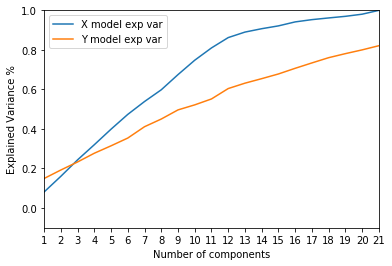

In [11]:
X, Y, _ = clean_confound(FC_yeo7, MRIQ, confound_raw)

X_scores, Y_scores, df_z = save_output(dataset, best_model, X, Y, path=None)
best_model.model_explained(X, Y)
best_model.model_evs_plot

In [ ]:
best_model.n

In [ ]:
joblib.dump(best_model, 
            './models/SCCA_Yeo7_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY))

set_text_size(12)
u, v = best_model.u, best_model.v

figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)

write_pdf('./reports/revision/bestModel_confoundclean_collection_nested_{0:1d}_{1:.1f}_{2:.1f}_.pdf'.format(
                best_model.n_components, best_model.penX, best_model.penY), figs)

In [ ]:
df_z.to_csv('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))